 # Snake vs Background Classifier using PyTorch

 This notebook is a binary classifier to distinguish between snake images and background images using a ResNet50 model with modified head.

 ## Imports and Setup

In [20]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import os
import zipfile
import shutil
from pathlib import Path
import requests
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import itertools
import random
from PIL import Image
import pandas as pd
import seaborn as sns

try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(4709471861038091579)

Using device: cuda


 ## Data Preparation

In [2]:
data_path = Path("data/")
if Path("data/Data").is_dir():
    print("Data directory exists")
else:
    print(f"Did not find {data_path} directory, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "AnimalSpeciesRecognition.zip", "wb") as f:
        request = requests.get("https://figshare.com/ndownloader/files/35784053")
        print("Downloading data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "AnimalSpeciesRecognition.zip", "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(data_path)

    os.remove(data_path / "AnimalSpeciesRecognition.zip")

base_dir = "data/Data"
main_dirs = ['train', 'test', 'valid']
dirs_to_delete = ['lizard', 'toad']

for main_dir in main_dirs:
    for dir_to_delete in dirs_to_delete:
        dir_path = os.path.join(base_dir, main_dir, dir_to_delete)
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
            print(f"Deleted: {dir_path}")
        else:
            print(f"Directory does not exist: {dir_path}")

train_dir = data_path / "Data/train"
valid_dir = data_path / "Data/valid"
test_dir = data_path / "Data/test"

Did not find data directory, creating one...
Unzipping data...
Deleted: data/Data/train/lizard
Deleted: data/Data/train/toad
Deleted: data/Data/test/lizard
Deleted: data/Data/test/toad
Deleted: data/Data/valid/lizard
Deleted: data/Data/valid/toad


 ## Data Transforms and Loaders

In [3]:
target_size = (224, 224)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(target_size),
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), shear=10, scale=(0.7, 1.3)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "valid": transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "test": transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
}

batch_size = 32
num_workers = os.cpu_count()

train_data = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms["valid"])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms["test"])

class_names = train_data.classes

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(valid_data)}")
print(f"Number of test samples: {len(test_data)}")
print(f"Classes: {class_names}")


Number of training samples: 2506
Number of validation samples: 500
Number of test samples: 200
Classes: ['background', 'snake']


 ## Visualize Sample Image

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


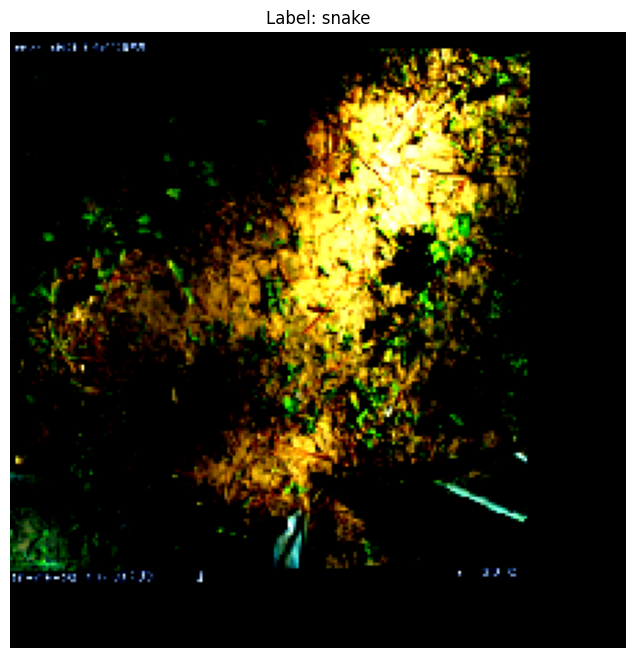

In [4]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.figure(figsize=(8, 8))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {class_names[label]}")
plt.axis('off')
plt.show()

 ## Model Setup

In [5]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1),
    nn.Sigmoid()
).to(device)

summary(model, input_size=(batch_size, 3, 224, 224), verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 41.7MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [18]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

 ## Training and Validation Functions

In [9]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y.unsqueeze(1).float())
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.round(y_pred)
        train_acc += (y_pred_class == y.unsqueeze(1)).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def valid_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: torch.device) -> Tuple[float, float]:
    model.eval()
    valid_loss, valid_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            valid_pred = model(X)
            loss = loss_fn(valid_pred, y.unsqueeze(1).float())
            valid_loss += loss.item()

            y_pred_class = torch.round(valid_pred)
            valid_acc += (y_pred_class == y.unsqueeze(1)).sum().item() / len(valid_pred)

    valid_loss /= len(dataloader)
    valid_acc /= len(dataloader)
    return valid_loss, valid_acc


In [10]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        valid_loss, valid_acc = valid_step(model, valid_dataloader, loss_fn, device)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    return results


 ## Model Training

In [11]:
epochs = 15
start_time = timer()
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, epochs, device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
torch.random.initial_seed()

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6871 | train_acc: 0.5775 | valid_loss: 0.6744 | valid_acc: 0.6824
Epoch: 2 | train_loss: 0.6600 | train_acc: 0.6486 | valid_loss: 0.6309 | valid_acc: 0.6961
Epoch: 3 | train_loss: 0.6057 | train_acc: 0.7059 | valid_loss: 0.5733 | valid_acc: 0.6902
Epoch: 4 | train_loss: 0.5612 | train_acc: 0.7216 | valid_loss: 0.5272 | valid_acc: 0.7297
Epoch: 5 | train_loss: 0.5209 | train_acc: 0.7616 | valid_loss: 0.4795 | valid_acc: 0.7777
Epoch: 6 | train_loss: 0.4970 | train_acc: 0.7762 | valid_loss: 0.4501 | valid_acc: 0.7953
Epoch: 7 | train_loss: 0.4601 | train_acc: 0.7997 | valid_loss: 0.4253 | valid_acc: 0.8168
Epoch: 8 | train_loss: 0.4354 | train_acc: 0.8135 | valid_loss: 0.4059 | valid_acc: 0.8176
Epoch: 9 | train_loss: 0.4200 | train_acc: 0.8267 | valid_loss: 0.3947 | valid_acc: 0.8266
Epoch: 10 | train_loss: 0.4019 | train_acc: 0.8229 | valid_loss: 0.3710 | valid_acc: 0.8324
Epoch: 11 | train_loss: 0.3942 | train_acc: 0.8341 | valid_loss: 0.3485 | valid_acc: 0.84

4709471861038091579

 ## Loading Pretrained Weights


In [9]:
def load_with_pretrained_weights(PATH: str):
  model = torchvision.models.resnet50(weights=weights).to(device)
  for param in model.parameters():
    param.requires_grad = False

  model.fc = nn.Sequential(
      nn.Linear(2048, 256),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(64, 1),
      nn.Sigmoid()
  ).to(device)
  model.load_state_dict(torch.load(PATH, weights_only=True))
  return model

In [10]:
model = load_with_pretrained_weights("/content/updated-snake-bg-model-weights-v2-ft.pth")

 ## Visualize Results

In [12]:
def plot_loss_curves(results: Dict[str, List]):
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], label="train_loss")
    plt.plot(results["valid_loss"], label="valid_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], label="train_acc")
    plt.plot(results["valid_acc"], label="valid_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show

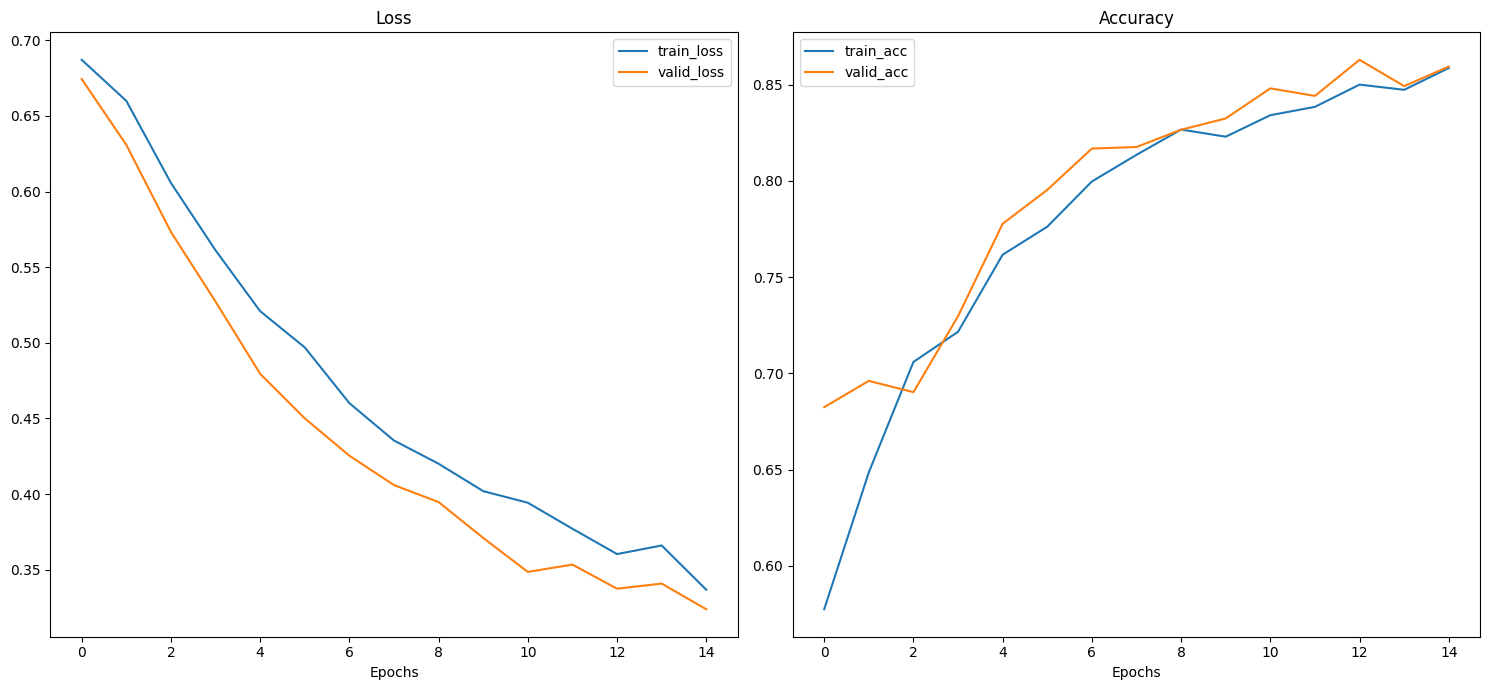

In [13]:
plot_loss_curves(results)

In [11]:
def pred_and_plot_image(img_path: str,
                        model: nn.Module =model,
                        class_names: List[str] = class_names,
                        img_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = data_transforms["test"],
                        device: torch.device=device):
  from PIL import Image

  img = Image.open(img_path)
  if transform is not None:
    img_transform = transform
  else:
    img_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225])
    ])

  model.to(device)

  model.eval()
  with torch.inference_mode():
    trans_img = img_transform(img).unsqueeze(dim=0)
    target_img_prob = model(trans_img.to(device))

  actual_label = img_path.split('/')[-2]
  target_img_label = torch.round(target_img_prob).to(torch.int8).item()
  target_img_prob = target_img_prob.to(torch.float16).item()

  plt.figure()
  plt.imshow(img)
  plt.title(f"True: {actual_label} | Pred: {class_names[target_img_label]} | Prob: {target_img_prob:.3f}")
  plt.axis(False)

In [12]:
def pred_and_plot_images_dataloader(dataloader: DataLoader = test_dataloader,
                         model: nn.Module = model,
                         class_names: List[str] = class_names,
                         img_size: Tuple[int, int] = (224, 224),
                         device: torch.device = device,
                         num_images: int = 5):
    model.to(device)
    model.eval()

    total_images = len(dataloader.dataset)

    random_indices = random.sample(range(total_images), num_images)
    rev_norm = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    ])
    with torch.inference_mode():
        for idx in random_indices:
            img, actual_label = dataloader.dataset[idx]
            img = img.unsqueeze(0).to(device)

            target_img_prob = model(img)
            target_img_label = torch.round(target_img_prob).to(torch.int8).item()
            target_img_prob = target_img_prob.to(torch.float16).item()

            img = rev_norm(img).squeeze(0).to("cpu")
            plt.figure()
            plt.imshow(img.permute(1, 2, 0))
            if class_names[actual_label] == "background":
                target_img_prob = 1 - target_img_prob
            plt.title(f"True: {class_names[actual_label]} | Pred: {class_names[target_img_label]} | Prob: {target_img_prob:.3f}")
            plt.axis(False)
            plt.show()

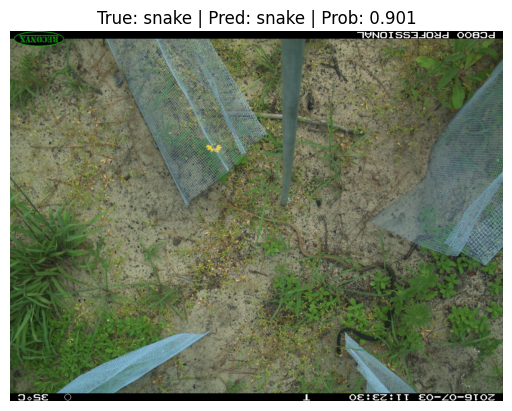

In [13]:
pred_and_plot_image("/content/data/Data/test/snake/180 (649).JPG")

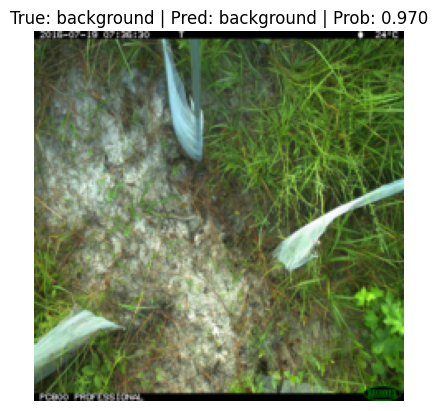

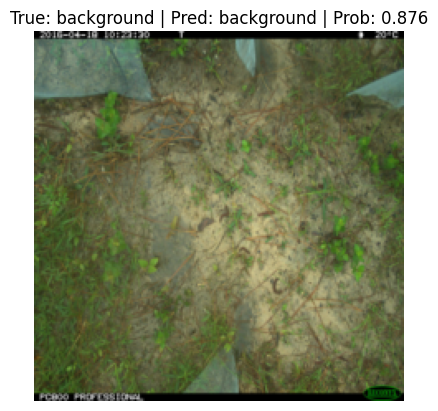

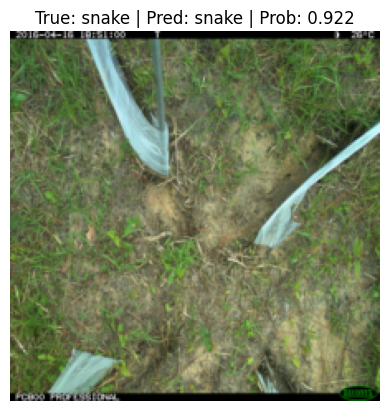

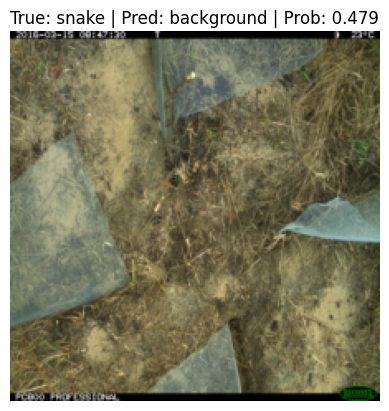

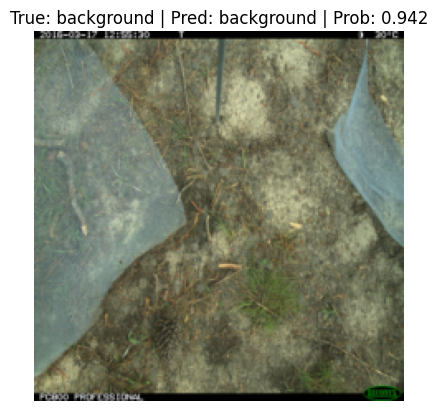

In [15]:
pred_and_plot_images_dataloader()

## Evaluation Metrics

In [16]:
import torch
from torch import nn
from typing import Tuple, Dict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device) -> Tuple[float, float, np.ndarray, np.ndarray]:
  model.eval()
  test_loss = 0
  all_predictions = []
  all_labels = []

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y.unsqueeze(1).float())
      test_loss += loss.item()

      y_pred_class = torch.round(test_pred)
      all_predictions.extend(y_pred_class.cpu().numpy())
      all_labels.extend(y.cpu().numpy())

  test_loss /= len(dataloader)
  all_predictions = np.array(all_predictions).flatten()
  all_labels = np.array(all_labels)

  return test_loss, all_predictions, all_labels

def test(model: nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: nn.Module,
         device: torch.device) -> Dict[str, float]:
  test_loss, all_predictions, all_labels = test_step(model, dataloader, loss_fn, device)

  # Calculate metrics
  accuracy = accuracy_score(all_labels, all_predictions)
  precision = precision_score(all_labels, all_predictions, zero_division=0)
  recall = recall_score(all_labels, all_predictions, zero_division=0)
  f1 = f1_score(all_labels, all_predictions, zero_division=0)

  # Generate classification report and confusion matrix
  class_report = classification_report(all_labels, all_predictions, output_dict=True)
  conf_matrix = confusion_matrix(all_labels, all_predictions)

  # Prepare results dictionary
  results = {
    "test_loss": test_loss,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "classification_report": class_report,
    "confusion_matrix": conf_matrix
  }

  return results

def visualize_results(results: Dict[str, float]):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

  sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax1)
  ax1.set_title('Confusion Matrix')
  ax1.set_xlabel('Predicted')
  ax1.set_ylabel('Actual')

  class_report = results['classification_report']
  del class_report['accuracy']

  report_df = pd.DataFrame(class_report).T
  report_df = report_df.drop('support', axis=1)

  sns.heatmap(report_df, annot=True, cmap='YlGnBu', ax=ax2)
  ax2.set_title('Classification Report')
  ax2.set_xlabel('Metrics')
  ax2.set_ylabel('Classes')

  plt.tight_layout()
  plt.show()

  print(f"Test Loss: {results['test_loss']:.4f}")
  print(f"Accuracy: {results['accuracy']:.4f}")
  print(f"Precision: {results['precision']:.4f}")
  print(f"Recall: {results['recall']:.4f}")
  print(f"F1 Score: {results['f1_score']:.4f}")

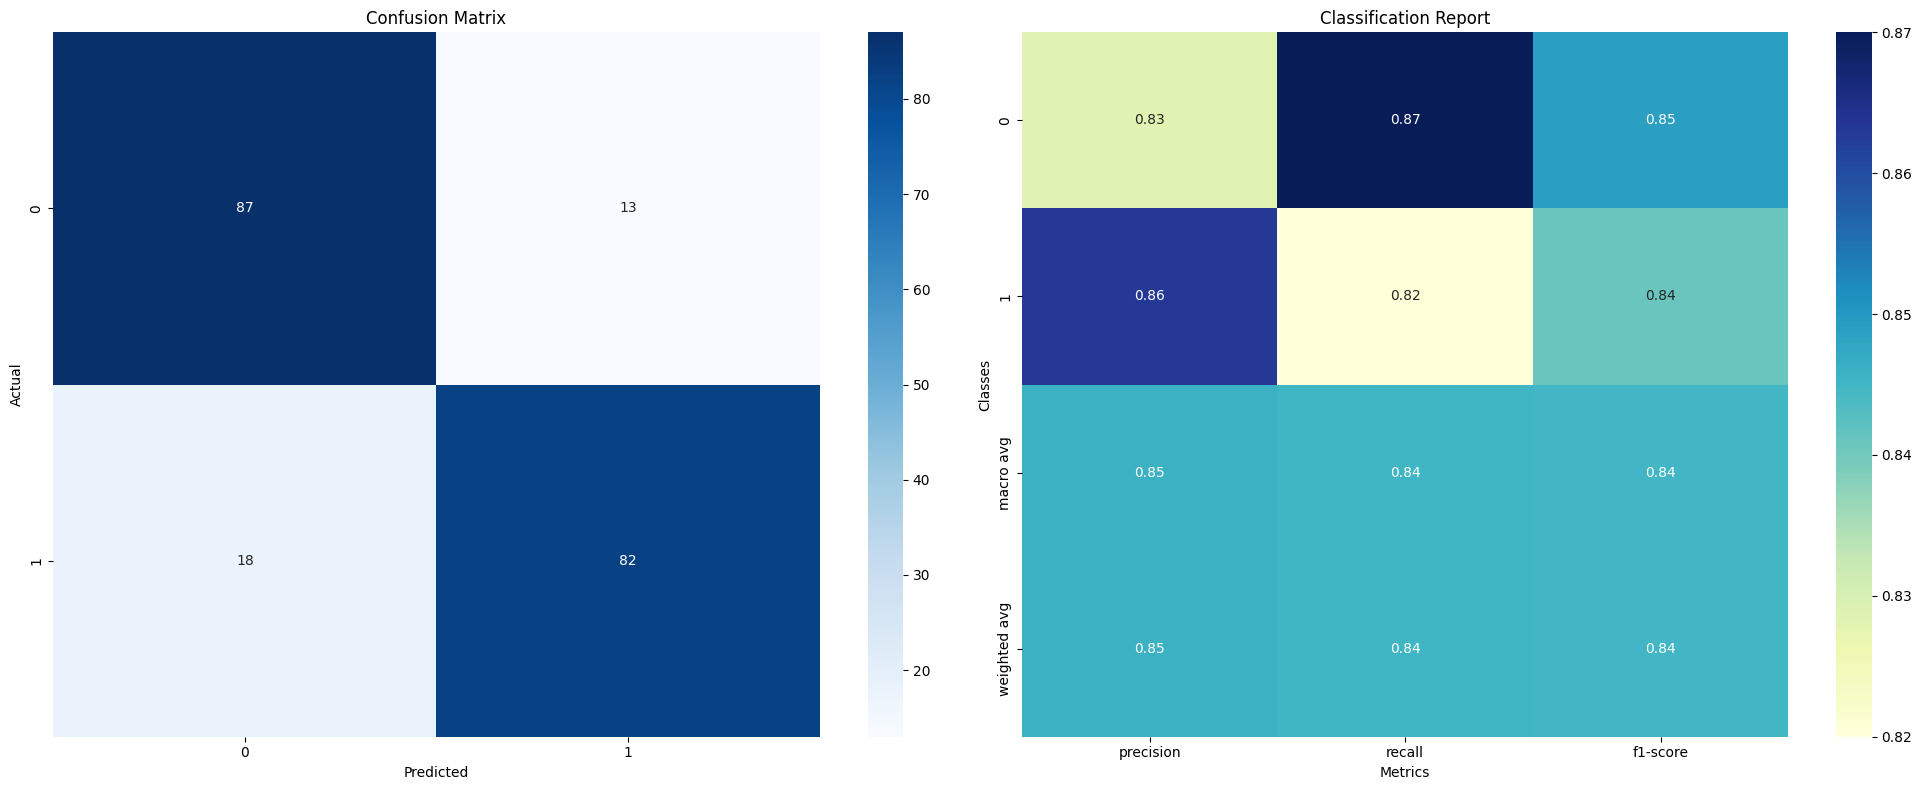

Test Loss: 0.3110
Accuracy: 0.8450
Precision: 0.8632
Recall: 0.8200
F1 Score: 0.8410


In [21]:
results = test(model, test_dataloader, loss_fn, device)
visualize_results(results)

># Misc


In [ ]:
torch.random.initial_seed() #4709471861038091579

4709471861038091579

In [19]:
PATH = "/content/updated-snake-bg-model-weights-v2-ft.pth"
torch.save(model.state_dict(), PATH)